# Auto-generate cover art for movies using facial detection

Problem: Apple has changed the "poster art" for movies from images shaped like posters (2:3), to 16:9 images, often using the dimensions of 1280x720.

Rather than search the internet for new cover art for movies, generate new cover art using facial detection to ensure actors are in the image.


## Here is a demo:

In [11]:
import numpy as np
import cv2
import matplotlib.pyplot as plt


face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')


file = "/Users/glog/Movies/TV/Media.localized/Movies/The Great Escape (1963)/The Great Escape (1963) (1080p HD).m4v"

#seconds = 900

cam = cv2.VideoCapture(file)

#frame_per_second = cam.get(cv2.CAP_PROP_FPS)
#print(frame_per_second)
#amount_of_frames = cam.get(cv2.CAP_PROP_FRAME_COUNT)
#print(amount_of_frames)

## Step 1: Search for faces

See this website for more info:
https://towardsdatascience.com/face-detection-in-2-minutes-using-opencv-python-90f89d7c0f81

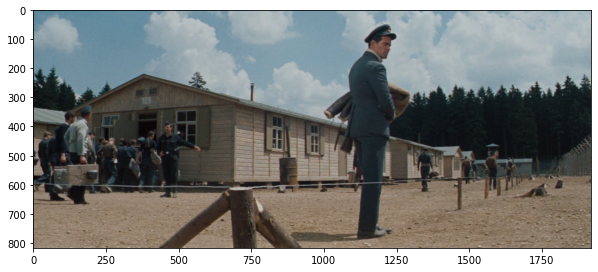

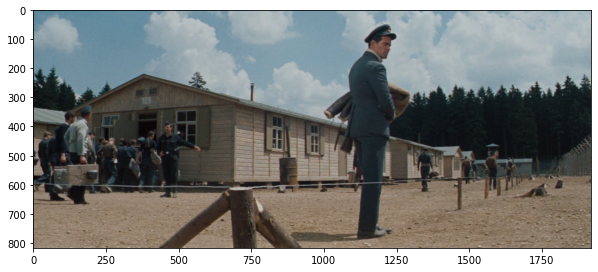

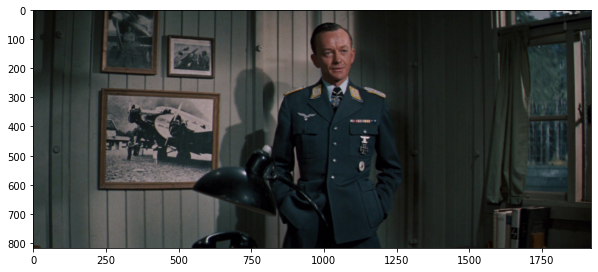

Size of face: 21025


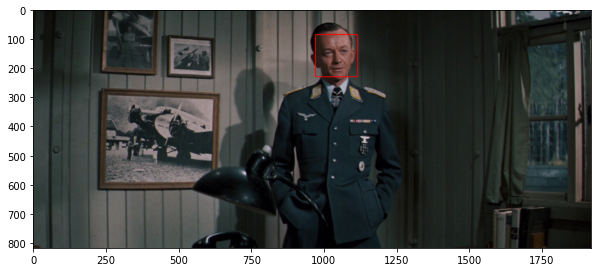

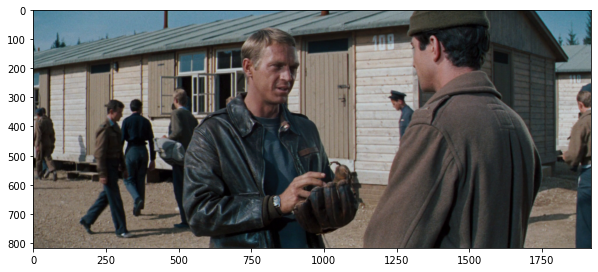

Size of face: 32761


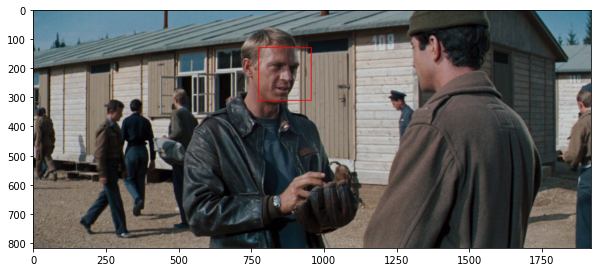

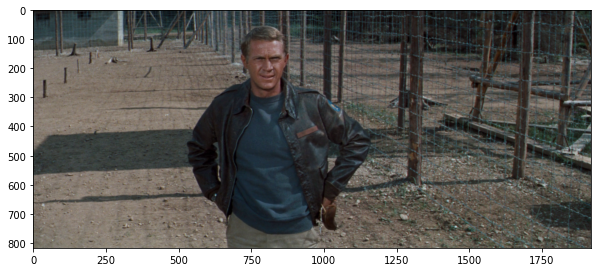

Size of face: 18769


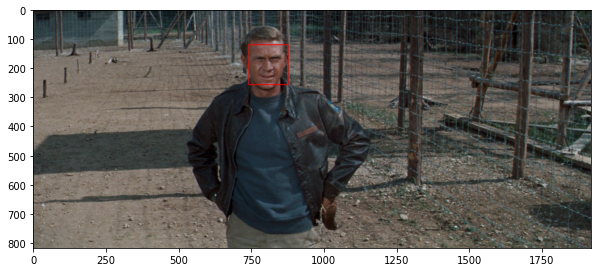

In [12]:

for seconds in [300, 600, 900, 1200]:
    
    cam.set(cv2.CAP_PROP_POS_MSEC, seconds * 1000) # optional
    success, image = cam.read()
    correct_color = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize = (10,10))
    plt.imshow(correct_color)
    plt.show()
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    
    rectangles = correct_color

    for (x, y, w, h) in faces:
        print("Size of face: " + str(w * h))
        cv2.rectangle(rectangles, (x, y), (x+w, y+h), (255, 0, 0), 2)
    
    plt.figure(figsize = (10,10))
    plt.imshow(rectangles)
    plt.show()


### Step 2. Create threshold to filter out candidate images

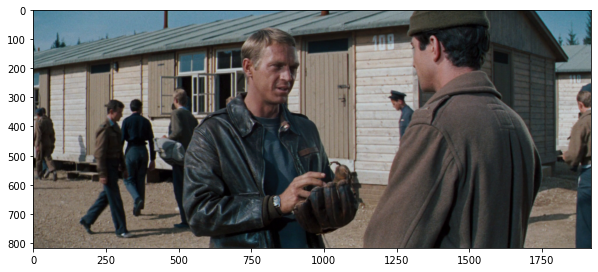

In [13]:
found_image = None

for seconds in [300, 600, 900, 1200]:
    
    cam.set(cv2.CAP_PROP_POS_MSEC, seconds * 1000) # optional
    success, image = cam.read()
    correct_color = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    


    for (x, y, w, h) in faces:
        if w*h > 32000:
            found_image = correct_color

    
plt.figure(figsize = (10,10))
plt.imshow(found_image)
plt.show()




### Step 3. Resize the image to Apple's new format

Once it has been determined that a face exists in the frame, the image needs to be properly formatted

(1689, 720)


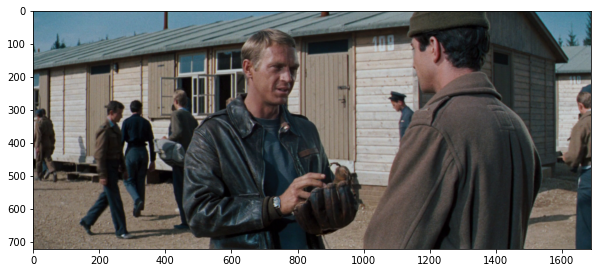

In [14]:
correct_color = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

width = found_image.shape[1]
height = found_image.shape[0]

max_height = 720
max_width = 1280

width_ratio = max_width / width
height_ratio = max_height / height

if width_ratio > height_ratio:
    dim = (int(width * width_ratio), int(height * width_ratio))
    
else:
    
    dim = (int(width * height_ratio), int(height * height_ratio))
    
print(dim)


resized = cv2.resize(found_image, dim, interpolation = cv2.INTER_AREA)


plt.figure(figsize = (10,10))
plt.imshow(resized)
plt.show()



### Step 4. Crop to proper dimensions
(image needs to be 1280x720)

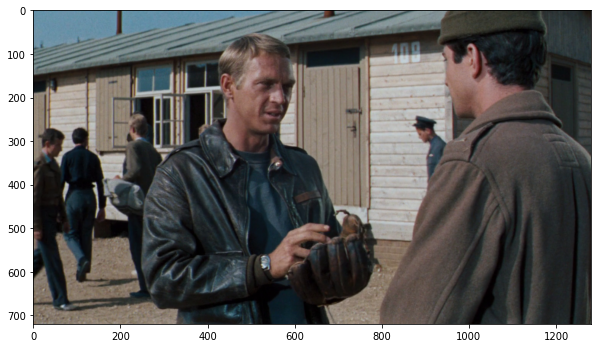

In [15]:
width = resized.shape[1]
height = resized.shape[0]

if width > max_width:
    trim_amount = width - max_width
    crop = resized[0:height, int(trim_amount/2):width-int(trim_amount/2)]
else:
    trim_amount = height - max_height
    crop = resized[int(trim_amount/2):height-int(trim_amount/2), 0:width ]

plt.figure(figsize = (10,10))
plt.imshow(crop)
plt.show()



### Step 5. Enhance the image


#### Use CLAHE (Contrast Limited AHE (Adaptive Histogram Equalization))

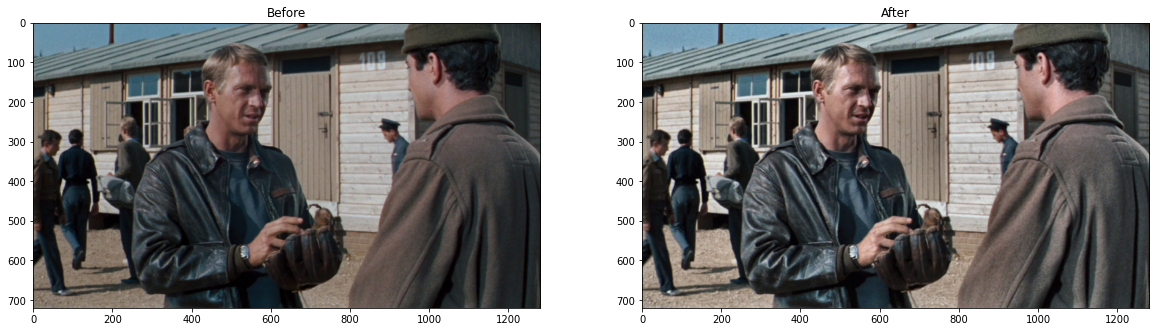

In [23]:


# Convert to LAB color space
lab = cv2.cvtColor(crop, cv2.COLOR_RGB2LAB)

# Split the channels out of the LAB image
lightness, color_channel_a, color_channel_b = cv2.split(lab)

# Create a Contrast Limited AHE with default values
clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(8,8))

# Apply it only only to the "Lightness" channel
enlightenment = clahe.apply(lightness)

# Create a new LAB image with enhanced L and original A & B channels
enlightened_lab = cv2.merge((enlightenment,
                             color_channel_a,
                             color_channel_b))



# Convert the LAB image to the RGB color space
enlightened_img = cv2.cvtColor(enlightened_lab, cv2.COLOR_LAB2RGB)


# Plot the result
fig, axes = plt.subplots(1,2, figsize = (20,20))
axes[0].set_title('Before')
axes[0].imshow(crop)
axes[1].set_title('After')
axes[1].imshow(enlightened_img)
plt.show()


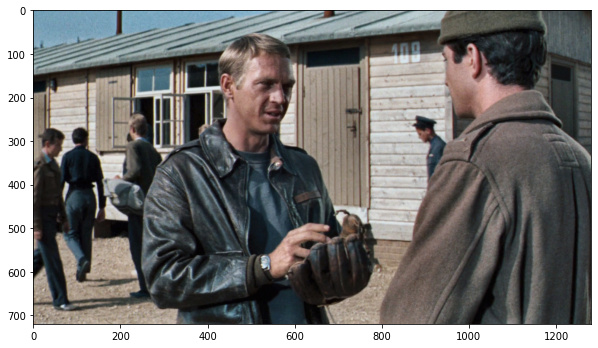

In [22]:
plt.figure(figsize = (10,10))
plt.imshow(enlightened_img)
plt.show()


This looks reasonable, but fuzzy

### Step 6. Sharpen the image

Since the images are used as "icons" on the Apple TV and in the desktop apps, they tend to look and scale better in the UI when they are sharpened.

#### Attept 1. Standard sharpen kernel

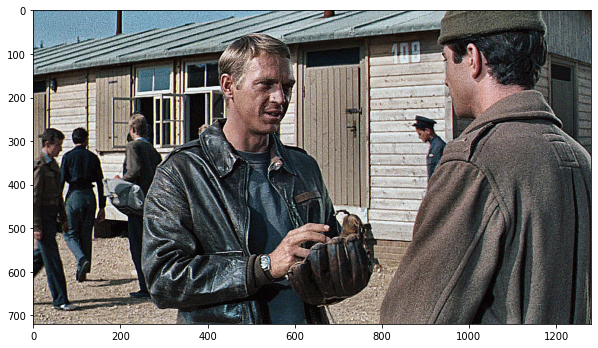

In [27]:


img_output = enlightened_img

kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
im = cv2.filter2D(img_output, -1, kernel)


plt.figure(figsize = (10,10))
plt.imshow(im)
plt.show()


The previous sharpen kernel is too severe. Try another...


#### Attempt 2. Try another kernel...

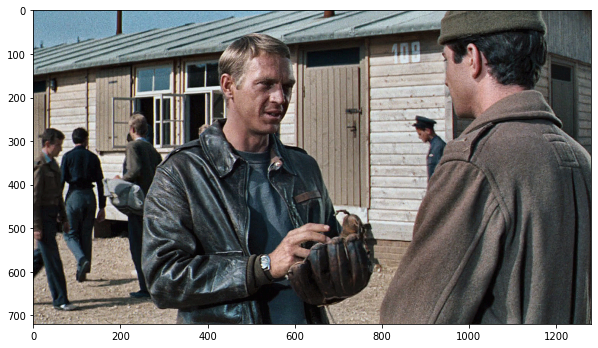

In [28]:
kernel = np.array([[0, -1,  0],[-1,  5, -1],[0, -1,  0]])

im = cv2.filter2D(img_output, -1, kernel)


plt.figure(figsize = (10,10))
plt.imshow(im)
plt.show()


## Success

This is an acceptable image to use as cover art for "The Great Escape" (1963)

### Step 7. Write the image to a file:

In [29]:
correct_color = cv2.cvtColor(im, cv2.COLOR_RGB2BGR)
cv2.imwrite("final_result.png", correct_color)

True

## Blind test

See if the code makes sense on a different movie

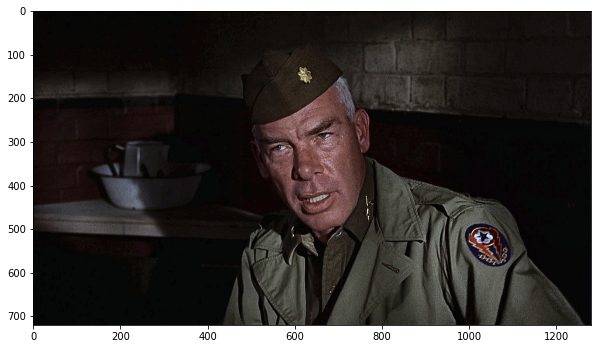

In [47]:
file = "/Users/glog/Movies/TV/Media.localized/Movies/The Dirty Dozen (1967)/The Dirty Dozen (1967) (1080p HD).m4v"

cam = cv2.VideoCapture(file)

found_image = None

for seconds in [300, 600, 900, 1200]:
    
    cam.set(cv2.CAP_PROP_POS_MSEC, seconds * 1000) # optional
    success, image = cam.read()
    correct_color = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    


    for (x, y, w, h) in faces:
        if w*h > 32000:
            found_image = correct_color

    
correct_color = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

width = found_image.shape[1]
height = found_image.shape[0]

max_height = 720
max_width = 1280

width_ratio = max_width / width
height_ratio = max_height / height

if width_ratio > height_ratio:
    dim = (int(width * width_ratio), int(height * width_ratio))
    
else:
    
    dim = (int(width * height_ratio), int(height * height_ratio))


resized = cv2.resize(found_image, dim, interpolation = cv2.INTER_AREA)

width = resized.shape[1]
height = resized.shape[0]

if width > max_width:
    trim_amount = width - max_width
    crop = resized[0:height, int(trim_amount/2):width-int(trim_amount/2)]
else:
    trim_amount = height - max_height
    crop = resized[int(trim_amount/2):height-int(trim_amount/2), 0:width ]

    


# Convert to LAB color space
lab = cv2.cvtColor(crop, cv2.COLOR_RGB2LAB)

# Split the channels out of the LAB image
lightness, color_channel_a, color_channel_b = cv2.split(lab)

# Create a Contrast Limited AHE with default values
clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(8,8))

# Apply it only only to the "Lightness" channel
enlightenment = clahe.apply(lightness)

# Create a new LAB image with enhanced L and original A & B channels
enlightened_lab = cv2.merge((enlightenment,
                             color_channel_a,
                             color_channel_b))



# Convert the LAB image to the RGB color space
enlightened_img = cv2.cvtColor(enlightened_lab, cv2.COLOR_LAB2RGB)



    
img_output = enlightened_img

kernel = np.array([[0, -1,  0],[-1,  5, -1],[0, -1,  0]])

im = cv2.filter2D(img_output, -1, kernel)


plt.figure(figsize = (10,10))
plt.imshow(im)
plt.show()


## Success

This is an acceptable image to use as cover art for "The Dirty Dozen" (1967)
